## Transporation mode choice modeling

Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban populace. Some of the key impact assessments from the model could be evaluating change in net commute time savings, change in pollution emissions, traffic volumes etc. across an urban area of interest.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model ridership across multiple modes by estimating mode choice between origin-destination taxi zone pairs in New York City among 4 available mode choices - transit, taxi, walking and driving. 

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.5
!pip install Theano==1.0.4

In [2]:
import pandas as pd
import numpy as np
from numpy import inf
import seaborn as sns
from scipy.stats import norm
import itertools
import theano
from theano import tensor as tt
import pymc3 as pm
import arviz
from matplotlib import pyplot as plt
%matplotlib inline

We use data from primarily two sources: 
- the travel duration and fare cost for taxi, transit and driving modes are extracted from Google Maps API for each of the origin-destination taxi zone pairs. Cost for walking is kept as 0.
- the mobility information and aggregated income information is retrieved from LEHD data along with ACS for origin-destination commute choice information, further aggregated on taxi zone levels.


The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving


In [3]:
# read the data

data = pd.read_csv('LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [4]:
data.ridership.sum()

191552556

In [5]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [6]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x7fa482ddda10>,
 [Text(0, 0, 'Transit'),
  Text(0, 0, 'Taxi'),
  Text(0, 0, 'Walking'),
  Text(0, 0, 'Driving')])

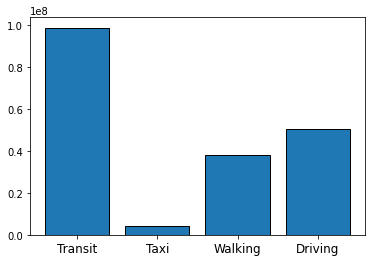

In [7]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

We use the Multinomial Logit (MNL) as the modeling framework for estimating the mode choice probabilities. MNL is broadly used in transportation choice modeling. It offers an advantage of estimating the mode-choice probabilities using closed-form formulas representing the aggregate-level choices.

the probabilities for each of the four major transportation modes to be chosen as having the highest utility is defined as
$$
\begin{equation}
    P_{mode} = \frac{e^{\lambda U_{mode}}}{e^{\lambda U_{taxi}} + e^{\lambda U_{transit}} + e^{\lambda U_{walk}} + e^{\lambda U_{drive}}}
\end{equation}
$$

$\lambda$ being subject to fit.

Additionally, we define the utilily below.

Mathematically, the utility score $U_j$ for alternative ${j}$ depends on the time taken $T_j$ between the O-D pair in consideration and the monetary cost $P_j$ for choosing the alternative, and a random component of error $\epsilon_j$ , yielding a base utility function
$$
\begin{equation}
    U_j = -(CT_j + P_j)
\end{equation}$$

where C is kept as a constant.

The utility can be interpreted as perceived total 'value' of commuting between a o-d pair by the commuter, incorporating possible irrationality of individual decisions while combining it with the direct monetary cost to assess the overall utility. An additional random error term $\epsilon$ can be added to the utility term following a particular distribution. This could be either an additive term or multiplicative term based on our preferences.
Here we will proceed with the additive case, so the utility being defined as $\begin{equation}
    U_j = -(CT_j + P_j) + \epsilon
\end{equation}$


#### Likelihood estimation

From the estimated probabilities $P_m$, we compute the likelihood of the observed C2SMART data give the model for each set of $\beta, \sigma$ parameters. For mode choice probabilities $P_m(o,d,\sigma,\beta)$ for each set of origin(o) and destination(d), the log-likelihood for four modes given the observed C2SMART ridership $R_m(o,d)$ is calculated as
$$
\begin{equation}
    L(\sigma, \beta) = \sum_{o,d}\sum_m R_m(o,d)\ln P_m(o,d,\sigma,\beta)
\end{equation}
$$


One can simulate the results just for the max-likelihood parameters, however comprehensive parameter sampling provides assessment with respect to the model uncertainty.



In [8]:
# choice for constant C - put as median hourly NYC income
# NYC median income is ~ $33,220 per year

C = 33220/(12*30*24)
C

3.8449074074074074

As defined in the utility function, the coefficient C can be interpreted as a parameter incorporating irrationality of decisions based on time and cost. 

We use the total number of hours in a day instead of number of working hours to assess the cost of time as people often underestimate the value of time.  So we try a lower bound value (which apparently also provides a better fit to the data). It could be a good idea to fit C as another parameter of the model, but we keep it fixed to make fitting easier for the illustration purposes.

Modeling:  We'll use Bayesian inference for fitting the model. There is just one parameter $\lambda$ in our model specifications. We will estimate it's posterior distribution from MCMC sampling.

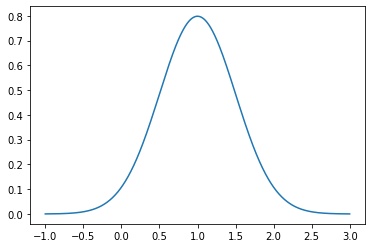

In [9]:
# prior for lambda 

fig, ax = plt.subplots()
x= np.arange(-1,3,0.001)
ax.plot(x, norm.pdf(x, loc=1, scale=0.5))

plt.show()

In [10]:
def MNL(lambda_, data):  # multinomial logit probabilities

    # compute probabilities from utility defined above
    prob_n = np.exp(lambda_*(-(np.random.normal(loc=data['duration'].values, scale=np.sqrt(data['duration'].values))*3.84 + 
                               np.random.normal(loc=data['price'].values, scale=np.sqrt(data['price'].values))) + np.random.normal(loc=0, scale=10)))
    prob_d = np.sum(prob_n)
    pred =  prob_n/prob_d
    return pred
    
def like(lambda_, obs=data['ridership'], return_prob=False):   # compute likelihood

    pred = []
    # scale = 10000**2

    # get MNL probabilities for each o-d travel modes
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
      data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):   # iterate each o-d
        odLoc = data[(data.pulocationid == o) & (data.dolocationid == d)]
        pred.append(MNL(lambda_, odLoc))

    pred = np.array(list(itertools.chain(*pred)))

    pred = pred.astype(float)
    pred[pred == 0] = 0.0001

    # return_prob argument is for getting numpy array vs tensor (required for MCMC sampling)
    if return_prob == True:
        return np.sum(np.log(pred)*obs)
    else:
        return tt.sum(tt.log(pred)*obs)

Let's estimate the posterior distribution of lambda parameter from MCMC simulations.

In [11]:
with pm.Model() as transport_model:
    lambda1 = pm.Normal('lambda', mu=1, sd=0.5) # lambda prior

    likelihood = pm.Potential('likelihood', like(lambda1.random(), data['ridership'])) ## likelihood, we call above likelihood function with 'Potential' in pymc3
    start = pm.find_MAP()  # find max likelihood
    trace = pm.sample(1000, start=start, progressbar=True) # estimate posterior from MCMC sampling

logp = -3.8037e+08, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 402.33it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda]
100%|██████████| 1500/1500 [00:00<00:00, 2158.20it/s]


<Figure size 720x720 with 0 Axes>

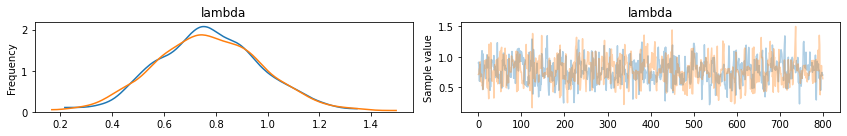

<Figure size 720x720 with 0 Axes>

In [12]:
fig = pm.traceplot(trace[199:1000])
plt.figure(figsize = (10, 10))

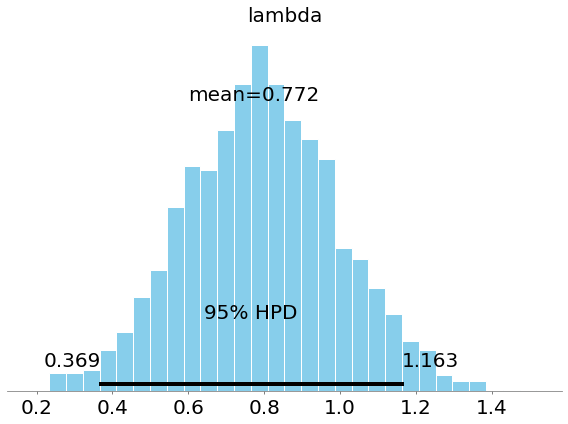

In [13]:
pm.plot_posterior(trace, figsize = (8, 6), text_size = 20);

In [14]:
# print max-likelihood lambda

print(start['lambda'])

0.77


### Assessing mode-shift in an intervention scenario

Now let's use the above model to evaluate the change in mobility across 4 modes when we impose an intervention case - additional surcharge of $3 for taxi rides anywhere in the city. One can expect a decrease in ridership for taxis owing to this intervention but assessing the mode-shift would enable to see how exactly the trips would redistribute across the other modes.

We will estimate the mode-shift numbers with respect to uncertainty by calculating the variance in trip numbers across all modes. This can be done by estimating variance of mode-shift numbers for lambdas drawn from posterior distribution, weighted by their likelihood values.

Now let's make another copy of data with the additional $3 surcharge to the taxi trips.

In [15]:
data1 = data.copy()  # make new df
data1.loc[data1.tmode == 3, 'price'] = data1.loc[data1.tmode == 3, 'price'] + 3
data1.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,46.157143,0
2,3,18,3,0.254000,15.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


Let's run the model and estimate aggregate mode-shift across modes w.r.t. uncertainty.

In [16]:
lambdas = np.random.choice(trace['lambda'], 10)  # draw samples from lambda posterior
# this step could take ~15 mins for 100 samples, reduce the number of samples for faster

likes = []   # likelihood values
mobDiff = {2:[], 3:[], 5:[], 8:[]}   # mode-shift numbers

# estimate trips for lambdas and corresponding likelihoods
for l in lambdas:
    tempMob_noInter = {2:0, 3:0, 5:0, 8:0}   
    tempMob_Inter = {2:0, 3:0, 5:0, 8:0}
    for o, d in zip(data[['pulocationid', 'dolocationid']].drop_duplicates()['pulocationid'], 
        data[['pulocationid', 'dolocationid']].drop_duplicates()['dolocationid']):
    
        odLoc_noInter = data[(data.pulocationid == o) & (data.dolocationid == d)]
        odLoc_Inter = data1[(data1.pulocationid == o) & (data1.dolocationid == d)]  
        modes = odLoc_Inter.tmode.values

        # probabilities for pre-intervention and post-intervention
        prob_noInter = MNL(l, odLoc_noInter)  
        prob_Inter = MNL(l, odLoc_Inter)    

        for index, mode in enumerate(modes):
            tempMob_Inter[mode] = tempMob_Inter[mode] + prob_Inter[index]*np.sum(odLoc_noInter['ridership'])
            tempMob_noInter[mode] = tempMob_noInter[mode] + prob_noInter[index]*np.sum(odLoc_Inter['ridership'])
        
    lhood = np.exp(like(l, return_prob=True))   # likelihood
    for it in mobDiff.keys():
        mobDiff[it].append(100.0 * tempMob_Inter[it] / tempMob_noInter[it] - 100.0)
    likes.append(lhood)
            # tempMob.update((x , y*l)for x, y in tempMob.items())

In [17]:
# calculate average and std of mode-shift numbers

for mode in mobDiff.keys():

    mean = np.average(mobDiff[mode])
    std = abs(np.average((mobDiff[mode] - np.mean(mobDiff[mode]))**2))
    print('average change for mode', mode, ':', mean, ', std:', np.sqrt(std))

average change for mode 2 : 2.666840071406824 , std: 1.3889803197270518
average change for mode 3 : -44.48737254017398 , std: 5.609705449034866
average change for mode 5 : 0.572600160672161 , std: 2.331862965937152
average change for mode 8 : 3.4864252657548946 , std: 3.8455272046576012


## HW tasks:

Assess the mode-shift impcats from:
1. for each additional \\$1, \\$5 and \\$10 to private car trips (tmode=8)

2. for \\$3 surcharge to taxi trips, but added only to trips originating from Manhattan.

you will need to read the NYC taxi zone shapefile from github. https://github.com/CUSP2021ADS/Data/blob/main/taxizone.geojson
